In [32]:
from google.cloud import bigquery

# Use raw string for the file path
key_path = r"C:\Phoenix Portfolio\phoenix-portfolio-461608-e794abe0cf71.json"

# Initialize the BigQuery client
client = bigquery.Client.from_service_account_json(key_path)

# Query table
query = """
    SELECT *
    FROM `bigquery-public-data.ml_datasets.credit_card_default`
    LIMIT 10000
"""
# Run the query and create a DataFrame
df = client.query(query).to_dataframe()

# Display the first few rows
print(df.head())

        id  limit_balance sex education_level marital_status   age  pay_0  \
0  27502.0        80000.0   1               6              1  54.0    0.0   
1  26879.0       200000.0   1               4              1  49.0    0.0   
2  18340.0        20000.0   2               6              2  22.0    0.0   
3  13692.0       260000.0   2               4              2  33.0    0.0   
4  20405.0       150000.0   1               4              2  32.0    0.0   

   pay_2  pay_3  pay_4  ... bill_amt_5 bill_amt_6  pay_amt_1  pay_amt_2  \
0    0.0    0.0    0.0  ...    26210.0    17643.0     2545.0     2208.0   
1    0.0    0.0    0.0  ...    50235.0    48984.0     1689.0     2164.0   
2    0.0    0.0    0.0  ...      500.0        0.0     4641.0     1019.0   
3    0.0    0.0    0.0  ...    30767.0    29890.0     5000.0     5000.0   
4    0.0    0.0   -1.0  ...   143375.0   146411.0     4019.0   146896.0   

   pay_amt_3  pay_amt_4  pay_amt_5  pay_amt_6  default_payment_next_month  \
0     133

In [33]:
#Initial Inspection
print("Dataset shape:", df.shape)
df.head()
print("\nInfo:")
print(df.info()) #understand the purpose of each function
print("\nSummary Statistics:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())
print(type(df))
for col in df.columns:
    print(col, type(df[col].iloc[0]))
df_no_ndarray = df.drop(columns=["predicted_default_payment_next_month"])
print("Duplicated Rows:", df_no_ndarray.duplicated().sum())
print("\nData Types:")
print(df.dtypes)

Dataset shape: (2965, 26)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    2965 non-null   float64
 1   limit_balance                         2965 non-null   float64
 2   sex                                   2965 non-null   object 
 3   education_level                       2965 non-null   object 
 4   marital_status                        2965 non-null   object 
 5   age                                   2965 non-null   float64
 6   pay_0                                 2965 non-null   float64
 7   pay_2                                 2965 non-null   float64
 8   pay_3                                 2965 non-null   float64
 9   pay_4                                 2965 non-null   float64
 10  pay_5                                 2965 non-null

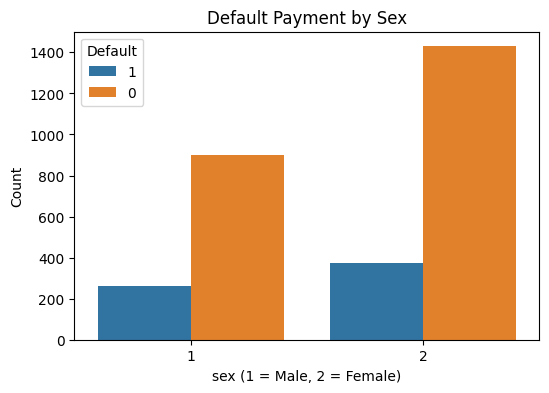

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
sns.countplot(x='sex', hue='default_payment_next_month', data=df)
plt.title("Default Payment by Sex")
plt.xlabel("sex (1 = Male, 2 = Female)")
plt.ylabel("Count")
plt.legend(title='Default')
plt.show()


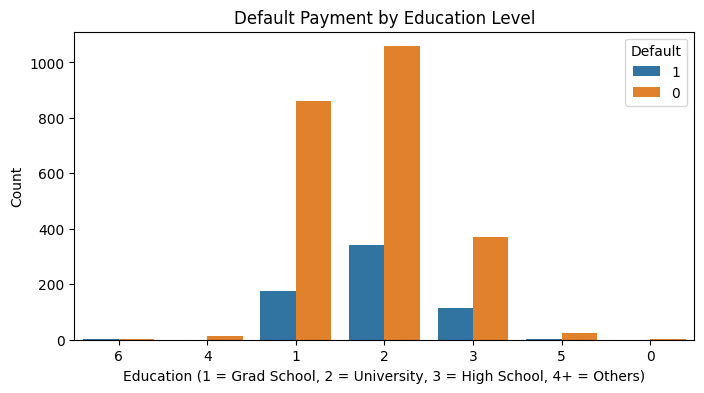

In [35]:
plt.figure(figsize=(8, 4))
sns.countplot(x='education_level', hue='default_payment_next_month', data=df)
plt.title("Default Payment by Education Level")
plt.xlabel("Education (1 = Grad School, 2 = University, 3 = High School, 4+ = Others)")
plt.ylabel("Count")
plt.legend(title='Default')
plt.show()


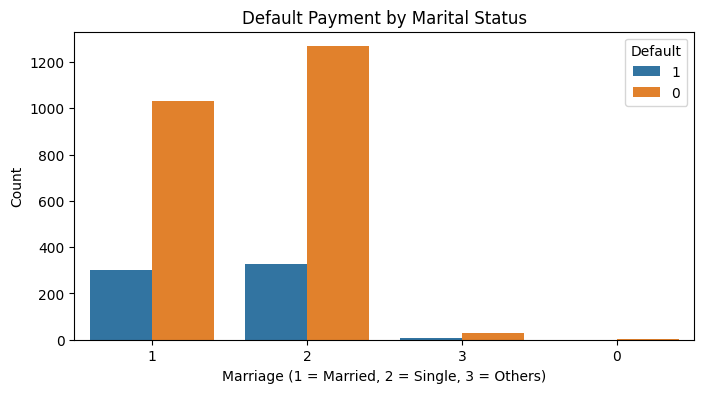

In [36]:
plt.figure(figsize=(8, 4))
sns.countplot(x='marital_status', hue='default_payment_next_month', data=df)
plt.title("Default Payment by Marital Status")
plt.xlabel("Marriage (1 = Married, 2 = Single, 3 = Others)")
plt.ylabel("Count")
plt.legend(title='Default')
plt.show()


In [37]:
import numpy as np
import pandas as pd

# Function to clean values
def clean_binary_column(val):
    # Handle lists/arrays with a single item
    if isinstance(val, (list, np.ndarray)) and len(val) == 1:
        val = val[0]
    elif isinstance(val, dict) and 'value' in val:
        val = val['value']
    # Try converting to numeric
    try:
        return int(float(val))
    except (ValueError, TypeError):
        return np.nan

# Apply cleaning
df['default_payment_next_month'] = df['default_payment_next_month'].apply(clean_binary_column)
df['default_payment_next_month'] = pd.to_numeric(df['default_payment_next_month'], errors='coerce')

# Drop invalid values and cast to int
df = df.dropna(subset=['default_payment_next_month'])
df['default_payment_next_month'] = df['default_payment_next_month'].astype(int)

# Confirm it worked
print(df['default_payment_next_month'].unique())
print(df['default_payment_next_month'].dtype)


[1 0]
int64


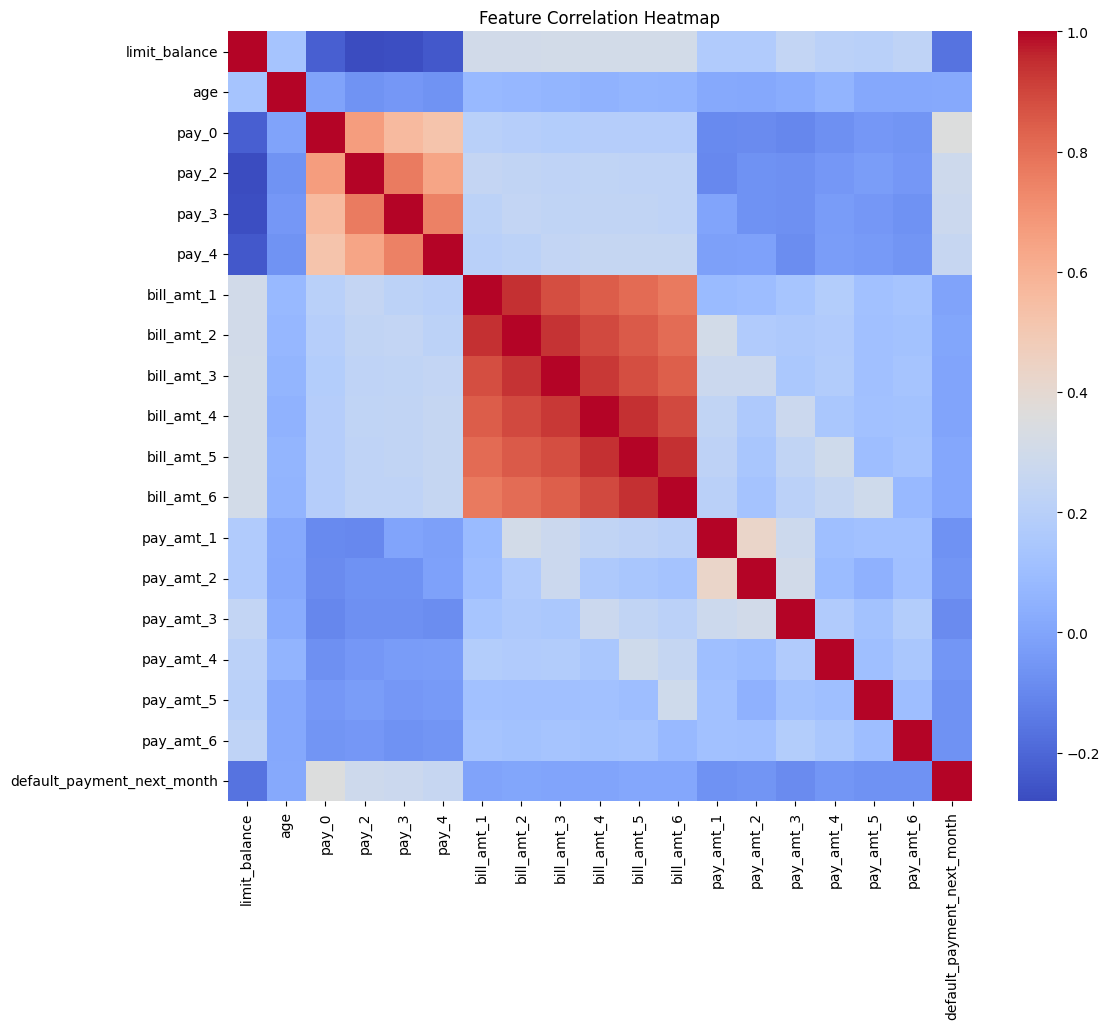


Correlation with 'default_payment_next_month':
default_payment_next_month    1.000000
pay_0                         0.356963
pay_2                         0.288813
pay_3                         0.275758
pay_4                         0.255805
age                           0.016905
bill_amt_6                    0.006116
bill_amt_5                    0.005930
bill_amt_2                    0.000877
bill_amt_3                   -0.001075
bill_amt_4                   -0.004718
bill_amt_1                   -0.005961
pay_amt_4                    -0.053684
pay_amt_2                    -0.059265
pay_amt_5                    -0.066159
pay_amt_1                    -0.066163
pay_amt_6                    -0.066966
pay_amt_3                    -0.090248
limit_balance                -0.161909
Name: default_payment_next_month, dtype: float64

Dropping highly correlated features:
['bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6']

Boxplots for numeric columns (checking for outliers)

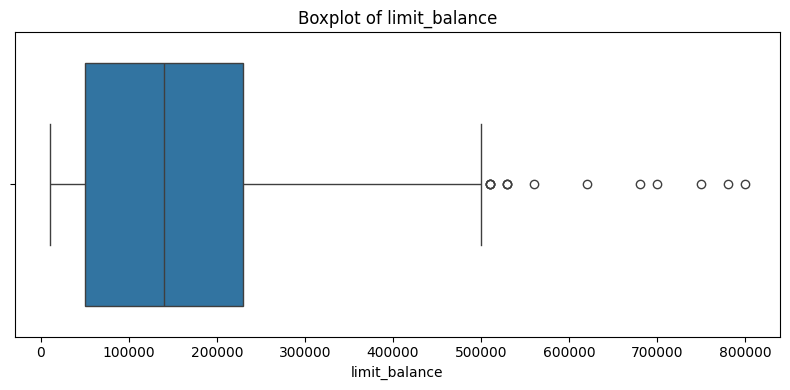

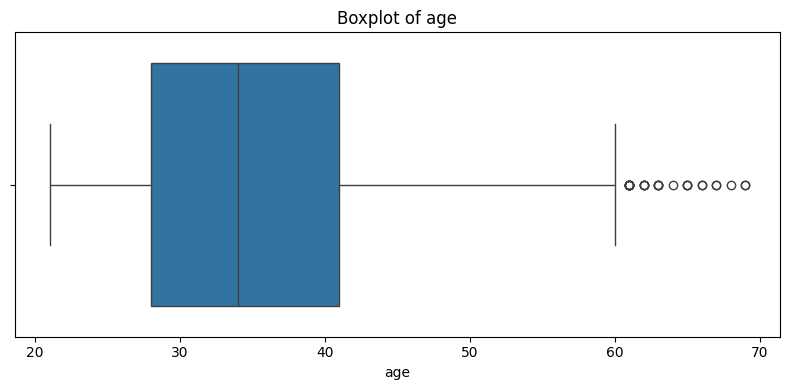

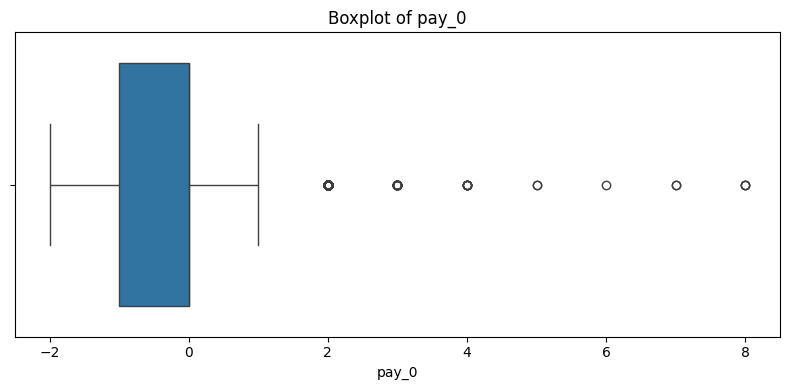

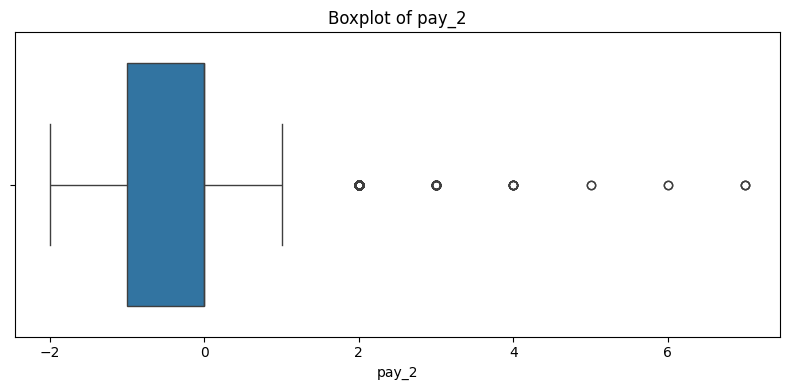

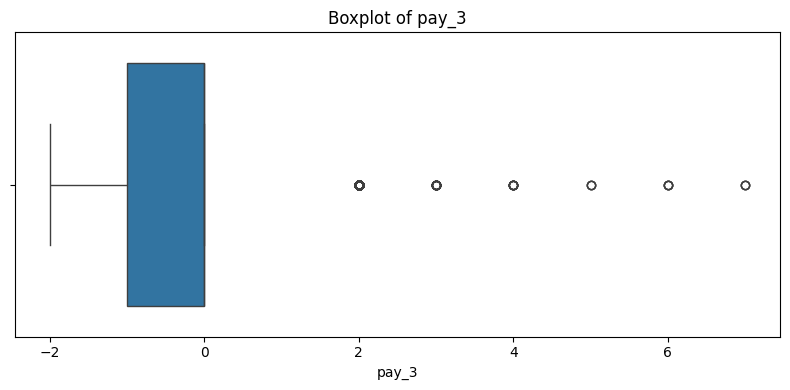

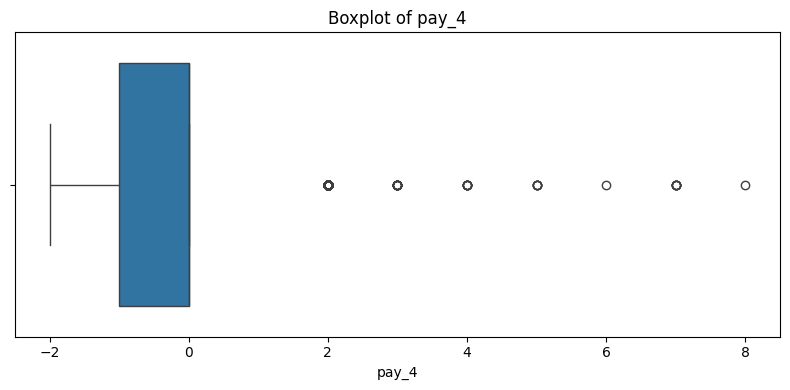

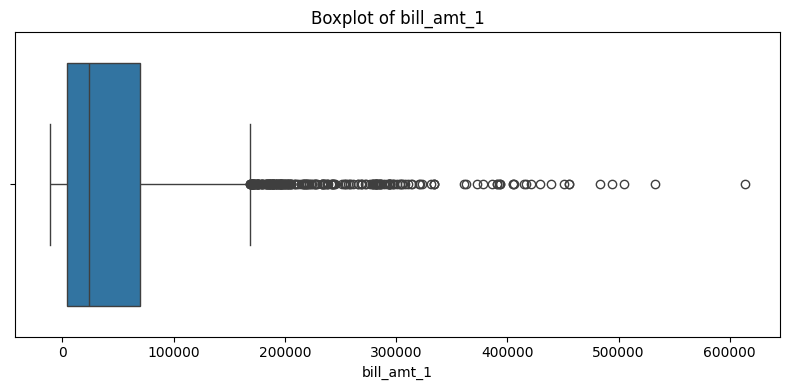

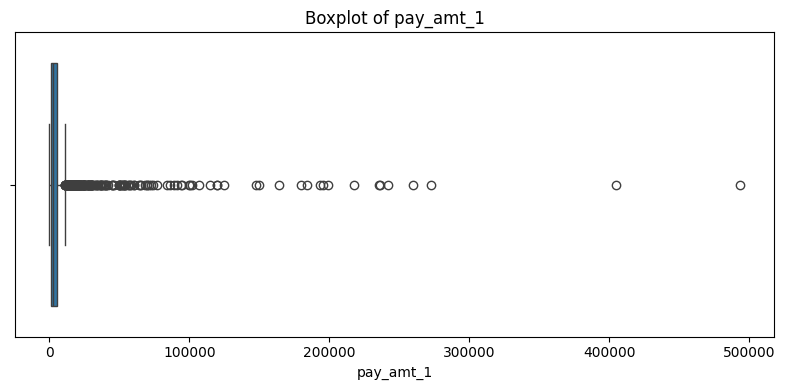

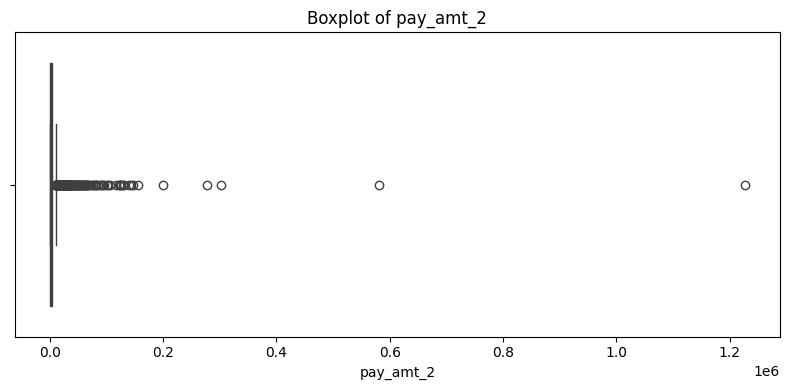

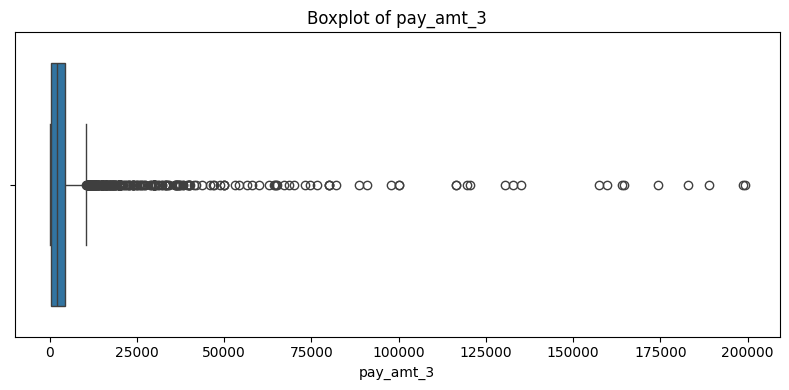

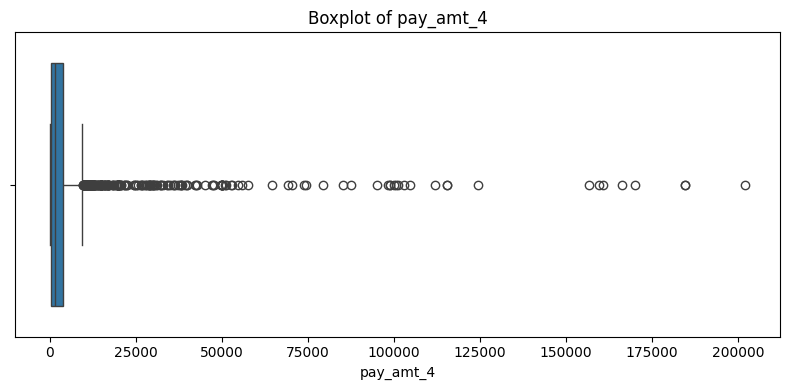

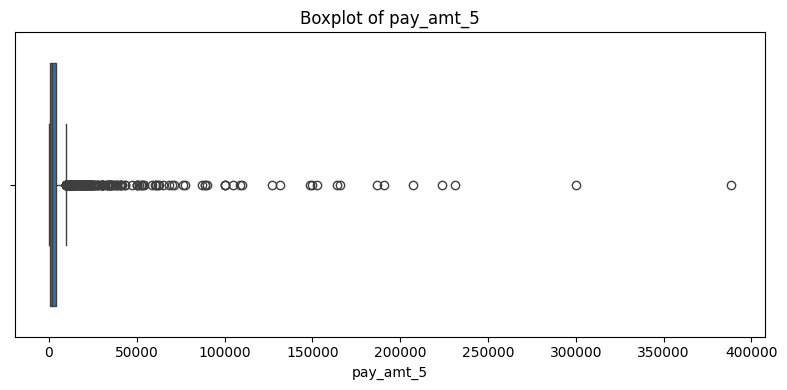

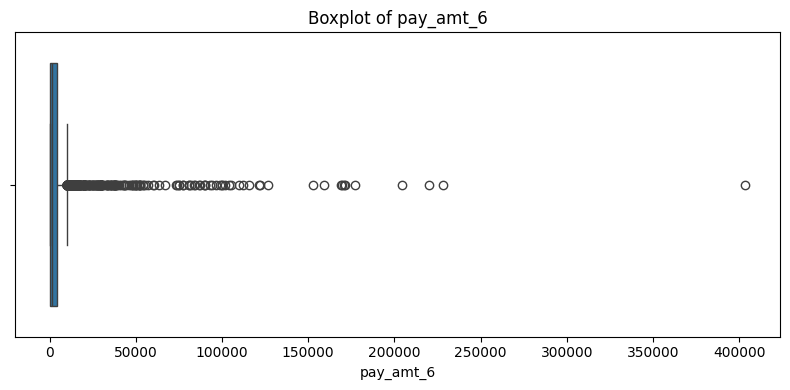

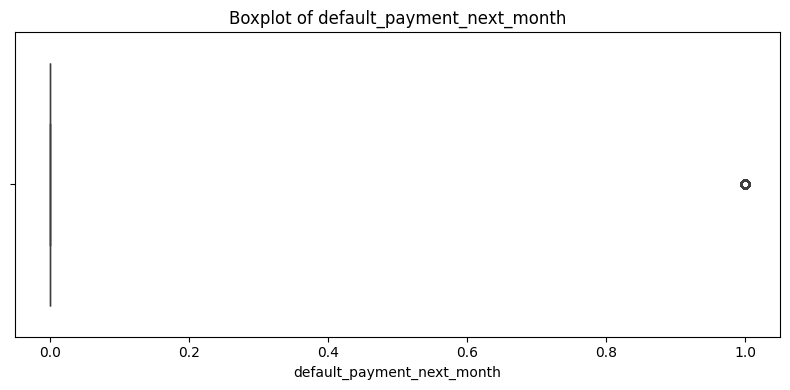

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Accept only numeric values
df_numeric = df.select_dtypes(include=[np.number]).copy()

# 2. Drop ID column if present
if 'id' in df_numeric.columns:
    df_numeric.drop(columns=['id'], inplace=True)

# 3. Drop missing values
df_numeric.dropna(inplace=True)

# 4. Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df_numeric.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

# 5. Correlation with target variable
target_col = "default_payment_next_month"
if target_col in df_numeric.columns:
    correlation = df_numeric.corr()[target_col].sort_values(ascending=False)
    print(f"\nCorrelation with '{target_col}':")
    print(correlation)
else:
    print(f"\nColumn '{target_col}' not found in df_numeric.")

# 6. Drop highly correlated features (multicollinearity filter)
#    Threshold can be adjusted (e.g., 0.8 or 0.9)
corr_matrix = df_numeric.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]

print(f"\nDropping highly correlated features:\n{to_drop}")
df_reduced = df_numeric.drop(columns=to_drop)


# 7. Box plots for outlier detection
print("\nBoxplots for numeric columns (checking for outliers)...")
for column in df_reduced.columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df_reduced, x=column)
    plt.title(f"Boxplot of {column}")
    plt.tight_layout()
    plt.show()


In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb


# Rename target column
df.rename(columns={"default_payment_next_month": "default"}, inplace=True)

# Drop ID column
if 'id' in df.columns:
    df.drop(columns=["id"], inplace=True)

# Drop rows with missing values
df.dropna(inplace=True)

# Split features and target
X = df.drop("default", axis=1)
y = df[["default"]]

# Keep only numeric features
X = X.select_dtypes(include=["number"])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_scaled, y_train)

# Predict
y_pred = model.predict(X_test_scaled)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


c:\Users\ADMIN\Desktop\Phoenix Analytics\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:43:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.7892074198988196

Confusion Matrix:
 [[420  46]
 [ 79  48]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87       466
           1       0.51      0.38      0.43       127

    accuracy                           0.79       593
   macro avg       0.68      0.64      0.65       593
weighted avg       0.77      0.79      0.78       593



In [40]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define the model
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='accuracy',      # You can change to 'roc_auc', 'f1', etc.
    cv=5,                     # 5-fold cross-validation
    verbose=1,                # Shows progress
    n_jobs=-1                # Use all CPU cores
)

# Fit the grid search to the training data
grid_search.fit(X_train_scaled, y_train.values.ravel())

# Best parameters and score
print("Best Parameters:\n", grid_search.best_params_)
print("\nBest Accuracy Score:", grid_search.best_score_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters:
 {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

Best Accuracy Score: 0.8398010215411947


c:\Users\ADMIN\Desktop\Phoenix Analytics\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:45:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [41]:
best_model = grid_search.best_estimator_

# Predict
y_pred = best_model.predict(X_test_scaled)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8026981450252951
Confusion Matrix:
 [[428  38]
 [ 79  48]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.92      0.88       466
           1       0.56      0.38      0.45       127

    accuracy                           0.80       593
   macro avg       0.70      0.65      0.67       593
weighted avg       0.78      0.80      0.79       593

